In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 10.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Using cached munch-2.5.0-py2.py3-none-any.whl (10 kB)
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16429 sha256=b25db7f234d5f3067521874851cd7105b7a213fab8619492d6b3216877e25703
  Stored in directory: /Users/ceyhun/Library/Caches/pip/wheels/85/0e/f1/ca6ec970b67cde79add7f1b56069a3f107fb6baefc2c9781a7
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=af9a012aa2491345bd7fec3a1d34a0dd6b208b42c831c579466b5e807d267610
  Stored in directory: /Users/ceyhun/Library/Caches/pip/wheels/de/6b/49/8c1f15e56a37b04cbcc6dc8cbe903a719fd21bfb74e94905a4
Successfully built ef

In [2]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 11.02 MiB/s, done.
Updating files: 100% (12939/12939), done.


In [4]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm#%%


In [1]:
DATA_DIR = 'Person-Re-Id-Dataset/train/'
CSV_FILE = 'Person-Re-Id-Dataset/train.csv'

BATCH_SIZE = 32
LR = 0.001
EPOCHS =5

device = 'cuda'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [7]:
row = df.iloc[114]
A_img = io.imread(DATA_DIR + row.Anchor)
N_img = io.imread(DATA_DIR + row.Negative)
P_img = io.imread(DATA_DIR + row.Positive)

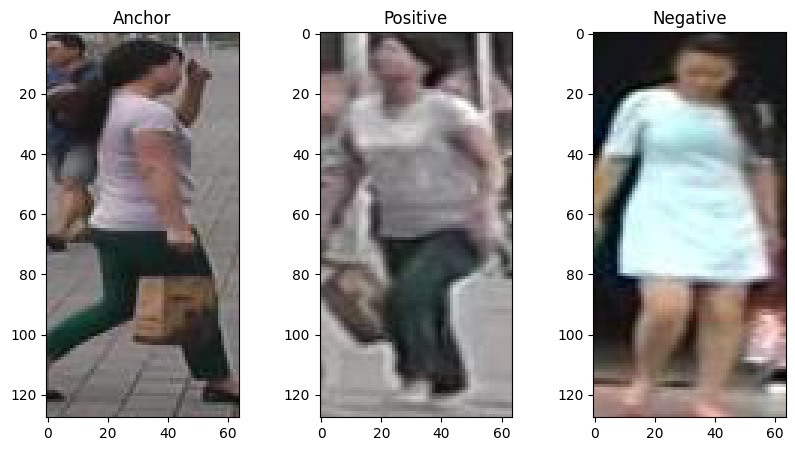

In [8]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (10,5))
ax1.set_title('Anchor')
ax1.imshow(A_img)

ax2.set_title('Positive')
ax2.imshow(P_img)

ax3.set_title('Negative')
ax3.imshow(N_img)

In [9]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

In [10]:
B_img = torch.from_numpy(P_img).permute(2,0,1)
B_img.shape

torch.Size([3, 128, 64])

In [11]:
class APN_Dataset(Dataset):

    def __init__(self, df) :
        self.df = df

    def __len__(self) :
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        A_img = io.imread(DATA_DIR + row.Anchor)
        N_img = io.imread(DATA_DIR + row.Negative)
        P_img = io.imread(DATA_DIR + row.Positive)

        A_img = torch.from_numpy(A_img).permute(2,0,1) / 255.0
        P_img = torch.from_numpy(P_img).permute(2,0,1) / 255.0
        N_img = torch.from_numpy(N_img).permute(2,0,1) / 255.0


        return A_img, P_img, N_img

In [12]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"size of trainset: {len(trainset)}")
print(f"size of validset: {len(validset)}")

size of trainset: 3200
size of validset: 800


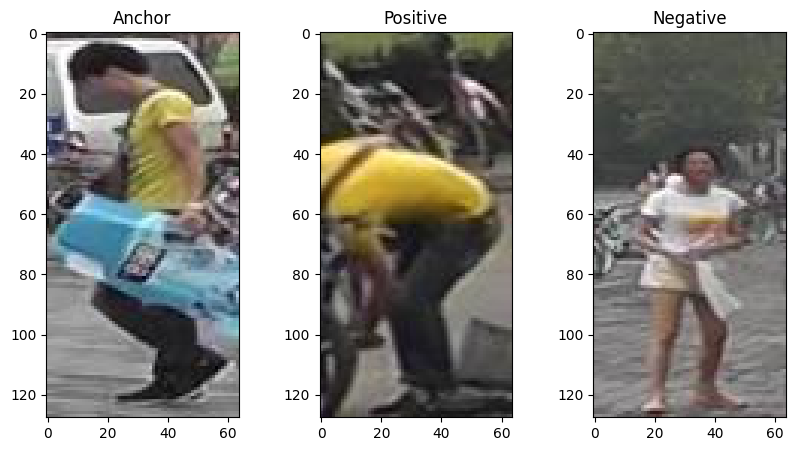

In [13]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

In [14]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE, shuffle = True)

In [15]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [16]:
A,P,N = next(iter(trainloader))

print(f"One image batch shape : {P.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


In [17]:
class APN_Model(nn.Module):
    def __init__(self, emb_size = 512) :
        super(APN_Model, self).__init__()

        self.efficientnet = timm.create_model('efficientnet_b0', pretrained = True)
        self.efficientnet.classifier = nn.Linear(in_features = self.efficientnet.classifier.in_features, out_features = emb_size)


    def forward(self, images) :
        embeddings = self.efficientnet(images)
        return embeddings

In [ ]:
model = APN_Model()
model.to(device)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /Users/ceyhun/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


In [2]:
def train_fn(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0

    for A,P,N in tqdm(dataloader):
        A,P,N = A.to(device),P.to(device),N.to(device)
        A_embs = model(A)
        P_embs = model(P)
        N_embs = model(N)

        loss = criterion(A_embs, P_embs, N_embs)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        total_loss +=loss.item()

    return total_loss / len(dataloader)

In [3]:
def eval_fn(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0

    with torch.no_grad() :

        for A,P,N in tqdm(dataloader):
            A,P,N = A.to(device),P.to(device),N.to(device)
            A_embs = model(A)
            P_embs = model(P)
            N_embs = model(N)

            loss = criterion(A_embs, P_embs, N_embs)

            total_loss +=loss.item()

        return total_loss / len(dataloader)

In [4]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

NameError: name 'nn' is not defined

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS) :
    train_loss = train_fn(model, trainloader, optimizer, criterion)
    valid_loss = eval_fn(model, validloader, criterion)

    if valid_loss < best_valid_loss :
        torch.save(model.state_dict(), 'best_model.pt')
        best_valid_loss = valid_loss
        print('SAVED WEIGHTS SUCCESS')

    print(f"EPOCHS : {i+1} train_loss : {train_loss}")

In [5]:
def get_encoding_csv(model, anc_img_names):
    anc_img_names_arr = np.array(anc_img_names)
    encodings = []

    model.eval()

    with torch.no_grad() :
        for i in tqdm(anc_img_names_arr):
            A = io.imread(DATA_DIR + i)
            A = torch.from_numpy(A).permute(2,0,1) / 255.0
            A = A.to(device)
            A_enc = model(A.unsqueeze(0))
            encodings.append(A_enc.squeeze().cpu().detach().numpy())

        encodings = np.array(encodings)
        encodings = pd.DataFrame(encodings)
        df_enc = pd.concat([anc_img_names, encodings], axis = 1)

    return df_enc

In [6]:
model.load_state_dict(torch.load('best_model.pt'))

NameError: name 'model' is not defined

In [7]:
df_enc = get_encoding_csv(model, df['Anchor'])

NameError: name 'model' is not defined

In [ ]:
df_enc.to_csv('database.csv', index = False)
df_enc.head()

In [ ]:
def euclidian_dist(img_enc, anc_enc_arr):
    dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc - anc_enc_arr).T))
    return dist#%%
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

In [ ]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

In [ ]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm#%%
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

In [ ]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

In [ ]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

In [ ]:
DATA_DIR = 'Person-Re-Id-Dataset/train/'
CSV_FILE = 'Person-Re-Id-Dataset/train.csv'

BATCH_SIZE = 32
LR = 0.001
EPOCHS =15

device = 'cuda'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

In [ ]:
row = df.iloc[114]
A_img = io.imread(DATA_DIR + row.Anchor)
N_img = io.imread(DATA_DIR + row.Negative)
P_img = io.imread(DATA_DIR + row.Positive)

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (10,5))
ax1.set_title('Anchor')
ax1.imshow(A_img)

ax2.set_title('Positive')
ax2.imshow(P_img)

ax3.set_title('Negative')
ax3.imshow(N_img)

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

In [ ]:
B_img = torch.from_numpy(P_img).permute(2,0,1)
B_img.shape

In [ ]:
class APN_Dataset(Dataset):

    def __init__(self, df) :
        self.df = df

    def __len__(self) :
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        A_img = io.imread(DATA_DIR + row.Anchor)
        N_img = io.imread(DATA_DIR + row.Negative)
        P_img = io.imread(DATA_DIR + row.Positive)

        A_img = torch.from_numpy(A_img).permute(2,0,1) / 255.0
        P_img = torch.from_numpy(P_img).permute(2,0,1) / 255.0
        N_img = torch.from_numpy(N_img).permute(2,0,1) / 255.0


        return A_img, P_img, N_img

In [ ]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"size of trainset: {len(trainset)}")
print(f"size of validset: {len(validset)}")

In [ ]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE, shuffle = True)

In [ ]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

In [ ]:
A,P,N = next(iter(trainloader))

print(f"One image batch shape : {P.shape}")

In [ ]:
class APN_Model(nn.Module):
    def __init__(self, emb_size = 512) :
        super(APN_Model, self).__init__()

        self.efficientnet = timm.create_model('efficientnet_b0', pretrained = True)
        self.efficientnet.classifier = nn.Linear(in_features = self.efficientnet.classifier.in_features, out_features = emb_size)


    def forward(self, images) :
        embeddings = self.efficientnet(images)
        return embeddings

In [ ]:
model = APN_Model()
model.to(device)

In [ ]:
def train_fn(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0

    for A,P,N in tqdm(dataloader):
        A,P,N = A.to(device),P.to(device),N.to(device)
        A_embs = model(A)
        P_embs = model(P)
        N_embs = model(N)

        loss = criterion(A_embs, P_embs, N_embs)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        total_loss +=loss.item()

    return total_loss / len(dataloader)

In [ ]:
def eval_fn(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0

    with torch.no_grad() :

        for A,P,N in tqdm(dataloader):
            A,P,N = A.to(device),P.to(device),N.to(device)
            A_embs = model(A)
            P_embs = model(P)
            N_embs = model(N)

            loss = criterion(A_embs, P_embs, N_embs)

            total_loss +=loss.item()

        return total_loss / len(dataloader)

In [ ]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS) :
    train_loss = train_fn(model, trainloader, optimizer, criterion)
    valid_loss = eval_fn(model, validloader, criterion)

    if valid_loss < best_valid_loss :
        torch.save(model.state_dict(), 'best_model.pt')
        best_valid_loss = valid_loss
        print('SAVED WEIGHTS SUCCESS')

    print(f"EPOCHS : {i+1} train_loss : {train_loss}")

In [ ]:
def get_encoding_csv(model, anc_img_names):
    anc_img_names_arr = np.array(anc_img_names)
    encodings = []

    model.eval()

    with torch.no_grad() :
        for i in tqdm(anc_img_names_arr):
            A = io.imread(DATA_DIR + i)
            A = torch.from_numpy(A).permute(2,0,1) / 255.0
            A = A.to(device)
            A_enc = model(A.unsqueeze(0))
            encodings.append(A_enc.squeeze().cpu().detach().numpy())

        encodings = np.array(encodings)
        encodings = pd.DataFrame(encodings)
        df_enc = pd.concat([anc_img_names, encodings], axis = 1)

    return df_enc

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))

In [ ]:
df_enc = get_encoding_csv(model, df['Anchor'])

In [ ]:
df_enc.to_csv('database.csv', index = False)
df_enc.head()

In [ ]:
def euclidian_dist(img_enc, anc_enc_arr):
    dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc - anc_enc_arr).T))
    return dist

In [ ]:
idx = 23
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2,0,1) / 255.

model.eval()

with torch.no_grad():
    img = img.to(device)
    img_enc = model(img.unsqueeze(0))
    img_enc = img_enc.detach().cpu().numpy()

In [ ]:
anc_enc_arr = df_enc.iloc[:, 1:]
anc_img_names = df_enc['Anchor']#%%
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

In [ ]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

In [ ]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm#%%
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

In [ ]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

In [ ]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

In [ ]:
DATA_DIR = 'Person-Re-Id-Dataset/train/'
CSV_FILE = 'Person-Re-Id-Dataset/train.csv'

BATCH_SIZE = 32
LR = 0.001
EPOCHS =15

device = 'cuda'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

In [ ]:
row = df.iloc[114]
A_img = io.imread(DATA_DIR + row.Anchor)
N_img = io.imread(DATA_DIR + row.Negative)
P_img = io.imread(DATA_DIR + row.Positive)

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (10,5))
ax1.set_title('Anchor')
ax1.imshow(A_img)

ax2.set_title('Positive')
ax2.imshow(P_img)

ax3.set_title('Negative')
ax3.imshow(N_img)

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

In [ ]:
B_img = torch.from_numpy(P_img).permute(2,0,1)
B_img.shape

In [ ]:
class APN_Dataset(Dataset):

    def __init__(self, df) :
        self.df = df

    def __len__(self) :
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        A_img = io.imread(DATA_DIR + row.Anchor)
        N_img = io.imread(DATA_DIR + row.Negative)
        P_img = io.imread(DATA_DIR + row.Positive)

        A_img = torch.from_numpy(A_img).permute(2,0,1) / 255.0
        P_img = torch.from_numpy(P_img).permute(2,0,1) / 255.0
        N_img = torch.from_numpy(N_img).permute(2,0,1) / 255.0


        return A_img, P_img, N_img

In [ ]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"size of trainset: {len(trainset)}")
print(f"size of validset: {len(validset)}")

In [ ]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE, shuffle = True)

In [ ]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

In [ ]:
A,P,N = next(iter(trainloader))

print(f"One image batch shape : {P.shape}")

In [ ]:
class APN_Model(nn.Module):
    def __init__(self, emb_size = 512) :
        super(APN_Model, self).__init__()

        self.efficientnet = timm.create_model('efficientnet_b0', pretrained = True)
        self.efficientnet.classifier = nn.Linear(in_features = self.efficientnet.classifier.in_features, out_features = emb_size)


    def forward(self, images) :
        embeddings = self.efficientnet(images)
        return embeddings

In [ ]:
model = APN_Model()
model.to(device)

In [ ]:
def train_fn(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0

    for A,P,N in tqdm(dataloader):
        A,P,N = A.to(device),P.to(device),N.to(device)
        A_embs = model(A)
        P_embs = model(P)
        N_embs = model(N)

        loss = criterion(A_embs, P_embs, N_embs)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        total_loss +=loss.item()

    return total_loss / len(dataloader)

In [ ]:
def eval_fn(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0

    with torch.no_grad() :

        for A,P,N in tqdm(dataloader):
            A,P,N = A.to(device),P.to(device),N.to(device)
            A_embs = model(A)
            P_embs = model(P)
            N_embs = model(N)

            loss = criterion(A_embs, P_embs, N_embs)

            total_loss +=loss.item()

        return total_loss / len(dataloader)

In [ ]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS) :
    train_loss = train_fn(model, trainloader, optimizer, criterion)
    valid_loss = eval_fn(model, validloader, criterion)

    if valid_loss < best_valid_loss :
        torch.save(model.state_dict(), 'best_model.pt')
        best_valid_loss = valid_loss
        print('SAVED WEIGHTS SUCCESS')

    print(f"EPOCHS : {i+1} train_loss : {train_loss}")

In [ ]:
def get_encoding_csv(model, anc_img_names):
    anc_img_names_arr = np.array(anc_img_names)
    encodings = []

    model.eval()

    with torch.no_grad() :
        for i in tqdm(anc_img_names_arr):
            A = io.imread(DATA_DIR + i)
            A = torch.from_numpy(A).permute(2,0,1) / 255.0
            A = A.to(device)
            A_enc = model(A.unsqueeze(0))
            encodings.append(A_enc.squeeze().cpu().detach().numpy())

        encodings = np.array(encodings)
        encodings = pd.DataFrame(encodings)
        df_enc = pd.concat([anc_img_names, encodings], axis = 1)

    return df_enc

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))

In [ ]:
df_enc = get_encoding_csv(model, df['Anchor'])

In [ ]:
df_enc.to_csv('database.csv', index = False)
df_enc.head()

In [ ]:
def euclidian_dist(img_enc, anc_enc_arr):
    dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc - anc_enc_arr).T))
    return dist#%%
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

In [ ]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

In [ ]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm#%%
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

In [ ]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

In [ ]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

In [ ]:
DATA_DIR = 'Person-Re-Id-Dataset/train/'
CSV_FILE = 'Person-Re-Id-Dataset/train.csv'

BATCH_SIZE = 32
LR = 0.001
EPOCHS =15

device = 'cuda'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

In [ ]:
row = df.iloc[114]
A_img = io.imread(DATA_DIR + row.Anchor)
N_img = io.imread(DATA_DIR + row.Negative)
P_img = io.imread(DATA_DIR + row.Positive)

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (10,5))
ax1.set_title('Anchor')
ax1.imshow(A_img)

ax2.set_title('Positive')
ax2.imshow(P_img)

ax3.set_title('Negative')
ax3.imshow(N_img)

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

In [ ]:
B_img = torch.from_numpy(P_img).permute(2,0,1)
B_img.shape

In [ ]:
class APN_Dataset(Dataset):

    def __init__(self, df) :
        self.df = df

    def __len__(self) :
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        A_img = io.imread(DATA_DIR + row.Anchor)
        N_img = io.imread(DATA_DIR + row.Negative)
        P_img = io.imread(DATA_DIR + row.Positive)

        A_img = torch.from_numpy(A_img).permute(2,0,1) / 255.0
        P_img = torch.from_numpy(P_img).permute(2,0,1) / 255.0
        N_img = torch.from_numpy(N_img).permute(2,0,1) / 255.0


        return A_img, P_img, N_img

In [ ]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"size of trainset: {len(trainset)}")
print(f"size of validset: {len(validset)}")

In [ ]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE, shuffle = True)

In [ ]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

In [ ]:
A,P,N = next(iter(trainloader))

print(f"One image batch shape : {P.shape}")

In [ ]:
class APN_Model(nn.Module):
    def __init__(self, emb_size = 512) :
        super(APN_Model, self).__init__()

        self.efficientnet = timm.create_model('efficientnet_b0', pretrained = True)
        self.efficientnet.classifier = nn.Linear(in_features = self.efficientnet.classifier.in_features, out_features = emb_size)


    def forward(self, images) :
        embeddings = self.efficientnet(images)
        return embeddings

In [ ]:
model = APN_Model()
model.to(device)

In [ ]:
def train_fn(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0

    for A,P,N in tqdm(dataloader):
        A,P,N = A.to(device),P.to(device),N.to(device)
        A_embs = model(A)
        P_embs = model(P)
        N_embs = model(N)

        loss = criterion(A_embs, P_embs, N_embs)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        total_loss +=loss.item()

    return total_loss / len(dataloader)

In [ ]:
def eval_fn(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0

    with torch.no_grad() :

        for A,P,N in tqdm(dataloader):
            A,P,N = A.to(device),P.to(device),N.to(device)
            A_embs = model(A)
            P_embs = model(P)
            N_embs = model(N)

            loss = criterion(A_embs, P_embs, N_embs)

            total_loss +=loss.item()

        return total_loss / len(dataloader)

In [ ]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS) :
    train_loss = train_fn(model, trainloader, optimizer, criterion)
    valid_loss = eval_fn(model, validloader, criterion)

    if valid_loss < best_valid_loss :
        torch.save(model.state_dict(), 'best_model.pt')
        best_valid_loss = valid_loss
        print('SAVED WEIGHTS SUCCESS')

    print(f"EPOCHS : {i+1} train_loss : {train_loss}")

In [ ]:
def get_encoding_csv(model, anc_img_names):
    anc_img_names_arr = np.array(anc_img_names)
    encodings = []

    model.eval()

    with torch.no_grad() :
        for i in tqdm(anc_img_names_arr):
            A = io.imread(DATA_DIR + i)
            A = torch.from_numpy(A).permute(2,0,1) / 255.0
            A = A.to(device)
            A_enc = model(A.unsqueeze(0))
            encodings.append(A_enc.squeeze().cpu().detach().numpy())

        encodings = np.array(encodings)
        encodings = pd.DataFrame(encodings)
        df_enc = pd.concat([anc_img_names, encodings], axis = 1)

    return df_enc

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))

In [ ]:
df_enc = get_encoding_csv(model, df['Anchor'])

In [ ]:
df_enc.to_csv('database.csv', index = False)
df_enc.head()

In [ ]:
def euclidian_dist(img_enc, anc_enc_arr):
    dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc - anc_enc_arr).T))
    return dist

In [ ]:
idx = 23
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2,0,1) / 255.

model.eval()

with torch.no_grad():
    img = img.to(device)
    img_enc = model(img.unsqueeze(0))
    img_enc = img_enc.detach().cpu().numpy()

In [ ]:
anc_enc_arr = df_enc.iloc[:, 1:]
anc_img_names = df_enc['Anchor']

In [ ]:
distance = []
for i in range(anc_enc_arr.shape[0]):
    dist = euclidian_dist(img_enc, anc_enc_arr.iloc[i : i + 1, :])
    distance = np.append(distance, dist)

In [ ]:
closest_idx = np.argsort(distance)

In [ ]:
closest_idx = np.argsort(distance)